In [1]:
import shutil

# importing the sys module
import sys        
 
# appending the directory of mod.py
# in the sys.path list
sys.path.append('../')   

import json
import os
import random
from collections import defaultdict

import torch
from PIL import Image
from torch import nn
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision import models
from torch.utils.data import DataLoader, WeightedRandomSampler
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
from torch.optim import lr_scheduler
from torch.optim import Adam
import numpy as np
from sklearn.model_selection import train_test_split

from datetime import datetime

from Common.Optimizers.RangerLars import RangerLars
from Common.Schedulers.GradualWarmupScheduler import GradualWarmupScheduler

import diff_pipeline4__config as cfg

from diff_pipeline4__dataset import DiffPipeline4SameUniformDiffDataset, DiffPipeline4MixedUniformDiffDataset, DiffPipeline4MimicDiffDataset, get_error_constrained_dataset
from Common.Datasets.Morph2.data_parser import DataParser
from diff_pipeline4__train import train_diff_cls_model_iter


from diff_pipeline4__model import DiffPipeline4Model, DiffPipeline4DeepModel, AgeDiffModel, DiffModelConfigType

from tqdm import tqdm

from sklearn import utils



#####################################################
#           Preparations
#####################################################

torch.manual_seed(cfg.RANDOM_SEED)
np.random.seed(cfg.RANDOM_SEED)
random.seed(cfg.RANDOM_SEED)

if cfg.USE_GPU:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")

print(device)

torch.cuda.empty_cache()

#####################################################
#           Data Loading
#####################################################

with open("im2age_map_test.json", 'r') as im2age_map_test_f:
    im2age_map_test = json.load(im2age_map_test_f)

# Load data
data_parser = DataParser('../Common/Datasets/Morph2/aligned_data/aligned_dataset_with_metadata_uint8.hdf5', small_data=cfg.SMALL_DATA)
data_parser.initialize_data()


x_train, y_train, x_test, y_test = data_parser.x_train,	data_parser.y_train, data_parser.x_test, data_parser.y_test,
if cfg.RANDOM_SPLIT:
    all_images = np.concatenate((x_train, x_test), axis=0)
    all_labels = np.concatenate((y_train, y_test), axis=0)

    x_train, x_test, y_train, y_test = train_test_split(all_images, all_labels, test_size=cfg.TEST_SIZE_FOR_RS, random_state=cfg.RANDOM_SEED)


cuda:0


In [2]:
import matplotlib.pyplot as plt

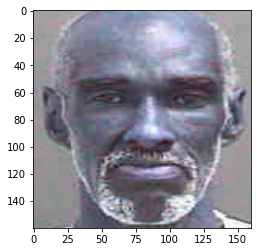

In [3]:
x_train[0].shape
plt.imshow(x_train[0])


In [4]:
face2emb_arr_trn_r = np.load('face2emb_arr_trn.npy', allow_pickle=True)
#     import pdb
#     pdb.set_trace()
#face2emb_arr_trn_r = face2emb_arr_trn_r.item()

face2emb_arr_vld_r = np.load('face2emb_arr_vld.npy', allow_pickle=True)
#face2emb_arr_vld_r = face2emb_arr_vld_r.item()

# shuffle basic aligned test
# x_test_shuffled
# y_test_shuffled


# transf = transforms.Compose([
#         transforms.RandomResizedCrop(224, (0.9, 1.0)),
#         transforms.RandomHorizontalFlip(),
#         transforms.RandomApply([transforms.ColorJitter(
#             brightness=0.1,
#             contrast=0.1,
#             saturation=0.1,
#             hue=0.1
#         )], p=0.5),
#         transforms.RandomApply([transforms.RandomAffine(
#             degrees=10,
#             translate=(0.1, 0.1),
#             scale=(0.9, 1.1),
#             shear=5,
#             resample=Image.BICUBIC
#         )], p=0.5),
#         transforms.ToTensor(),
#         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#         transforms.RandomErasing(p=0.5)
#     ])

transf = transforms.Compose([
        transforms.Resize(224), # just for testing
#          transforms.RandomResizedCrop(224, (0.9, 1.0)),
#          transforms.RandomHorizontalFlip(),
        transforms.RandomApply([transforms.ColorJitter(
            brightness=0.1,
            contrast=0.1,
            saturation=0.1,
            hue=0.1
        )], p=0.5),
#         transforms.RandomApply([transforms.RandomAffine(
#             degrees=10,
#             translate=(0.1, 0.1),
#             scale=(0.9, 1.1),
#             shear=5,
#             resample=Image.BICUBIC
#         )], p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#        transforms.RandomErasing(p=0.5)
    ])


train_ds = DiffPipeline4SameUniformDiffDataset(
    data_set_images=x_train,
    data_set_metadata=y_train,
    min_age=cfg.MIN_AGE,
    age_interval=cfg.AGE_INTERVAL,
    max_age=cfg.MAX_AGE,
    transform=transf,
    copies=1, 
    age_radius=cfg.AGE_RADIUS,
    age_diff_learn_radius_lo=cfg.AGE_DIFF_LEARN_RADIUS_LO,
    age_diff_learn_radius_hi=cfg.AGE_DIFF_LEARN_RADIUS_HI,
    embs=face2emb_arr_trn_r,
    num_references=cfg.NUM_OF_REFS
)

print("Training (q trn, r trn) set size: " + str(len(train_ds)))

test_qtst_rtst_ds = DiffPipeline4SameUniformDiffDataset(
    data_set_images=x_test,
    data_set_metadata=y_test,
    min_age=cfg.MIN_AGE,
    age_interval=cfg.AGE_INTERVAL,
    max_age=cfg.MAX_AGE,
    transform=transf,
    copies=1, 
    age_radius=cfg.AGE_RADIUS,
    age_diff_learn_radius_lo=cfg.AGE_DIFF_LEARN_RADIUS_LO,
    age_diff_learn_radius_hi=cfg.AGE_DIFF_LEARN_RADIUS_HI,
    embs=face2emb_arr_vld_r,
    num_references=cfg.NUM_OF_REFS
)

print("Testing (q tst, r tst) set size: " + str(len(test_qtst_rtst_ds)))

test_qtst_rtrn_ds = DiffPipeline4MixedUniformDiffDataset(
    batrn_set_images=x_train,
    batrn_set_metadata=y_train,
    batst_set_images=x_test,
    batst_set_metadata=y_test,
    min_age=cfg.MIN_AGE,
    age_interval=cfg.AGE_INTERVAL,
    max_age=cfg.MAX_AGE,
    transform=transf,
    copies=1, 
    age_radius=cfg.AGE_RADIUS,
    age_diff_learn_radius_lo=cfg.AGE_DIFF_LEARN_RADIUS_LO,
    age_diff_learn_radius_hi=cfg.AGE_DIFF_LEARN_RADIUS_HI,
    embs_trn=face2emb_arr_trn_r,
    embs_vld=face2emb_arr_vld_r,
    num_references=cfg.NUM_OF_REFS
)

print("Testing (q tst, r trn) set size: " + str(len(test_qtst_rtrn_ds)))

x_test_filtered, y_test_filtered, batst_set_filtered_indexes = get_error_constrained_dataset(orig_dataset_images=x_test, 
                                                                                                orig_dataset_metadata=y_test,
                                                                                                age_diff_learn_radius_lo=cfg.APREF_VLD_SET_AGE_DIFF_LEARN_RADIUS_LO,
                                                                                                age_diff_learn_radius_hi=cfg.APREF_VLD_SET_AGE_DIFF_LEARN_RADIUS_HI,#cfg.AGE_DIFF_LEARN_RADIUS_HI,
                                                                                                im2age_map_batst=im2age_map_test)

# apref = Age Predict Reference (dataset is based on (q,r) pairs where r's age is what AgePredict model returns on q)
test_apref_ds = DiffPipeline4MimicDiffDataset(
    batrn_set_images=x_train,
    batrn_set_metadata=y_train,
    batst_set_images=x_test_filtered,
    batst_set_metadata=y_test_filtered,
    batst_set_indexes=batst_set_filtered_indexes,
    im2age_map_batst=im2age_map_test,
    min_age=cfg.MIN_AGE,
    age_interval=cfg.AGE_INTERVAL,
    max_age=cfg.MAX_AGE,
    transform=transf,
    copies=1, 
    age_radius=cfg.AGE_RADIUS,
    embs_trn=face2emb_arr_trn_r,
    embs_vld=face2emb_arr_vld_r,
    num_references=cfg.NUM_OF_REFS
)

print("Testing (q tst where AgePredict(q)  {age_diff_learn_radius_lo} <= error <= {age_diff_learn_radius_hi}, r trn where age(r)=AgePredict(q)) set size: ".format(age_diff_learn_radius_lo=cfg.AGE_DIFF_LEARN_RADIUS_LO, age_diff_learn_radius_hi=cfg.AGE_DIFF_LEARN_RADIUS_HI) + str(len(test_apref_ds)))

x_test_all, y_test_all, batst_set_all_indexes = get_error_constrained_dataset(orig_dataset_images=x_test, 
                                                                                                orig_dataset_metadata=y_test,
                                                                                                age_diff_learn_radius_lo=cfg.AGE_DIFF_LEARN_RADIUS_LO,
                                                                                                age_diff_learn_radius_hi=35,#cfg.AGE_RADIUS,
                                                                                                im2age_map_batst=im2age_map_test)


# apref = Age Predict Reference (dataset is based on (q,r) pairs where r's age is what AgePredict model returns on q)
# test_apref_all_ds = DiffPipeline4MimicDiffDataset(
# 	batrn_set_images=x_train,
# 	batrn_set_metadata=y_train,
#     batst_set_images=x_test_all,
#     batst_set_metadata=y_test_all,
#     batst_set_indexes=batst_set_all_indexes,
#     im2age_map_batst=im2age_map_test,
# 	min_age=cfg.MIN_AGE,
# 	age_interval=cfg.AGE_INTERVAL,
#     max_age=cfg.MAX_AGE,
# 	transform=transf,
#     copies=1, 
#     age_radius=cfg.AGE_RADIUS,
#     embs_trn=face2emb_arr_trn_r,
#     embs_vld=face2emb_arr_vld_r#,
#     #num_references=cfg.NUM_OF_REFS
# )

# print("Testing (q tst where AgePredict(q)  {age_diff_learn_radius_lo} <= error <= {age_diff_learn_radius_hi}, r trn where age(r)=AgePredict(q)) set size: ".format(age_diff_learn_radius_lo=cfg.AGE_DIFF_LEARN_RADIUS_LO, age_diff_learn_radius_hi=35) + str(len(test_apref_all_ds))) #cfg.AGE_RADIUS





image_datasets = {
    'train': train_ds,
    'val_qtst_rtst': test_qtst_rtst_ds,
    'val_qtst_rtrn': test_qtst_rtrn_ds,
    'val_apref_ds': test_apref_ds,
    #'val_apref_all_ds': test_apref_all_ds
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val_qtst_rtst', 'val_qtst_rtrn', 'val_apref_ds']}#, 'val_apref_all_ds']}

data_loaders = {
    'train': DataLoader(train_ds, batch_size=cfg.BATCH_SIZE, num_workers=cfg.NUM_OF_WORKERS_DATALOADER, pin_memory=True, shuffle=True, drop_last=True),
    'val_qtst_rtst': DataLoader(test_qtst_rtst_ds, batch_size=cfg.BATCH_SIZE, num_workers=cfg.NUM_OF_WORKERS_DATALOADER, pin_memory=True, shuffle=False, drop_last=True),
    'val_qtst_rtrn': DataLoader(test_qtst_rtrn_ds, batch_size=cfg.BATCH_SIZE, num_workers=cfg.NUM_OF_WORKERS_DATALOADER, pin_memory=True, shuffle=False, drop_last=True),
    'val_apref_ds': DataLoader(test_apref_ds, batch_size=cfg.BATCH_SIZE, num_workers=cfg.NUM_OF_WORKERS_DATALOADER, pin_memory=True, shuffle=False, drop_last=True),
    #'val_apref_all_ds' : DataLoader(test_apref_all_ds, batch_size=cfg.BATCH_SIZE, num_workers=cfg.NUM_OF_WORKERS_DATALOADER, pin_memory=True, shuffle=False, drop_last=True)
}

Training (q trn, r trn) set size: 1000
Testing (q tst, r tst) set size: 250
Testing (q tst, r trn) set size: 250
Testing (q tst where AgePredict(q)  4 <= error <= 10, r trn where age(r)=AgePredict(q)) set size: 45


In [5]:
# samples = []
# for i, batch in enumerate(data_loaders['train']):
#     samples.append(batch)
#     if i == 5:
#         break

In [6]:
# #print(batch['image_vec'][0][0].reshape((224,224,3)).shape)
# #samples[0]['image_vec'].shape
# #print(samples[0]['bla'])
# fig, ax = plt.subplots(2, 4, figsize=(12, 8))

# for i in range(2):
#     for j in range(4):
#         ax[i][j].imshow(samples[0]['image_vec'][j][i].permute(1, 2, 0).numpy())
        
# diffs_str = ""
# for j in range(4):
#     diffs_str += "          " + str(float(samples[0]['age_diff'][j])) + "          "

# print(diffs_str)

# # plt.imshow(samples[0]['image_vec'][0][0].permute(1, 2, 0).numpy())
# # plt.imshow(samples[0]['image_vec'][0][1].permute(1, 2, 0).numpy())
# #plt.imshow(samples[0]['image_vec'][0][0].reshape((160,160,3)))
# #plt.imshow(samples[0]['image_vec'][0][0].reshape((224,224,3)))
# #plt.imshow(samples[0]['image_vec'][0][1].reshape((224,224,3)))

In [7]:
#####################################################
#           Model
#####################################################


# create model and parameters
if cfg.DEEP_MODEL:
    # model = DiffPipeline4DeepModel(age_interval=cfg.AGE_INTERVAL, 
    #                         min_age=cfg.MIN_AGE, 
    #                         max_age=cfg.MAX_AGE, 
    #                         age_radius=cfg.AGE_RADIUS, 
    #                         device=device)#,
                            #num_references=cfg.NUM_OF_REFS)

    model = AgeDiffModel(age_interval=cfg.AGE_INTERVAL, 
                            min_age=cfg.MIN_AGE, 
                            max_age=cfg.MAX_AGE, 
                            age_radius=cfg.AGE_RADIUS, 
                            device=device, 
                            deep=True, 
                            num_references=cfg.NUM_OF_REFS,#cfg.NUM_OF_REFERENCES, 
                            config_type=DiffModelConfigType.AddedEmbeddingAndMlpHeadWithDiffHead, 
                            added_embed_layer_size=512, 
                            diff_embed_layer_size=512,
                            is_ordinal_reg=True)
else:
    model = DiffPipeline4Model(age_interval=cfg.AGE_INTERVAL, 
                            min_age=cfg.MIN_AGE, 
                            max_age=cfg.MAX_AGE, 
                            age_radius=cfg.AGE_RADIUS, 
                            device=device)


if cfg.UNFREEZE_FEATURE_EXT_ON_RLVNT_EPOCH:
    model.freeze_base_cnn(True)

if cfg.USE_GPU and cfg.MULTI_GPU:
    if torch.cuda.device_count() > 1:
        print("Using multiple GPUs (" + str(torch.cuda.device_count()) + ")")
        model = torch.nn.DataParallel(model)

model.to(device)

criterion = torch.nn.CrossEntropyLoss().to(device)

if cfg.OPTIMIZER == "RangerLars":
    optimizer = RangerLars(model.parameters(), lr=cfg.LEARNING_RATE)
else:
    optimizer = Adam(model.parameters(), lr=cfg.LEARNING_RATE)

if cfg.SCHEDULER == "CosineAnnealingLR+GradualWarmupScheduler":
    cosine_scheduler = CosineAnnealingLR(
        optimizer,
        T_max=cfg.NUM_ITERS
    )
    scheduler = GradualWarmupScheduler(
        optimizer,
        multiplier=1,
        total_epoch=10000,
        after_scheduler=cosine_scheduler
    )
else:
    scheduler = None

Using multiple GPUs (2)


In [ ]:
#####################################################
#           Logging
#####################################################


 ### Train ###

cur_time = datetime.now()
cur_time_str = cur_time.strftime("time_%d_%m_%Y_%H_%M_%S")
experiment_name = cur_time_str

writer = SummaryWriter('logs/Morph2Diff/unified/iter/' + experiment_name) 

model_path = 'weights/Morph2Diff/unified/iter/' + experiment_name
if not os.path.exists(model_path):
    os.makedirs(model_path)


shutil.copyfile("diff_pipeline4__config.py", model_path + "/config.py")


#####################################################
#           Training
#####################################################

best_diff_model = train_diff_cls_model_iter(
    model,
    criterion,
    optimizer,
    scheduler,
    data_loaders,
    dataset_sizes,
    device,
    writer,
    model_path,
    num_epochs=cfg.NUM_EPOCHS,
    unfreeze_feature_ext_epoch=cfg.UNFREEZE_FEATURE_EXT_EPOCH,
    unfreeze_feature_ext_on_rlvnt_epoch=cfg.UNFREEZE_FEATURE_EXT_ON_RLVNT_EPOCH,
    validate_at_k=cfg.VALIDATION_PERIOD_ITERS,
    validate_at_end_of_epoch=cfg.VALIDATE_AT_END_OF_EPOCH,
    min_class=cfg.APREF_VLD_SET_AGE_DIFF_LEARN_RADIUS_LO,
    max_class=cfg.APREF_VLD_SET_AGE_DIFF_LEARN_RADIUS_HI
)


print('saving best model')

FINAL_MODEL_FILE = os.path.join(model_path, "weights.pt")
torch.save(best_diff_model.state_dict(), FINAL_MODEL_FILE)

  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

Epoch 0/59
----------
> d:\projects\age_estimation\diffpipeline4\diff_pipeline4__dataset.py(320)_find_ref_image()
    318         pdb.set_trace()
    319 
--> 320         if len(near_ne_in_range) < self.num_references:
    321             selected_idxs = np.random.choice(near_ne_in_range, self.num_references)
    322         else:

ipdb> selected_diff
*** NameError: name 'selected_diff' is not defined
ipdb> selected_diff
*** NameError: name 'selected_diff' is not defined
ipdb> next
> d:\projects\age_estimation\diffpipeline4\diff_pipeline4__dataset.py(323)_find_ref_image()
    321             selected_idxs = np.random.choice(near_ne_in_range, self.num_references)
    322         else:
--> 323             selected_idxs = np.random.choice(near_ne_in_range, self.num_references, replace=False)
    324         return selected_idxs
    325 

ipdb> next
> d:\projects\age_estimation\diffpipeline4\diff_pipeline4__dataset.py(324)_find_ref_image()
    322         else:
    323             selected

ipdb> next
> d:\projects\age_estimation\diffpipeline4\diff_pipeline4__dataset.py(353)__getitem__()
    351         ref_image_arr = [self.transform(ref_image) for ref_image in ref_image_arr]
    352         ref_image_arr_metadata = [json.loads(self.data_set_metadata[idx_i]) for idx_i in ref_image_idx]
--> 353         ref_image_arr_age = [int(ref_image_metadata['age']) for ref_image_metadata in ref_image_arr_metadata]
    354 
    355         # import pdb

ipdb> n
> d:\projects\age_estimation\diffpipeline4\diff_pipeline4__dataset.py(358)__getitem__()
    356         # pdb.set_trace()
    357 
--> 358         ref_image_label = ref_image_arr_age[0] #// self.age_interval
    359 
    360         scaled_radius = self.age_radius #// self.age_interval

ipdb> n
> d:\projects\age_estimation\diffpipeline4\diff_pipeline4__dataset.py(360)__getitem__()
    358         ref_image_label = ref_image_arr_age[0] #// self.age_interval
    359 
--> 360         scaled_radius = self.age_radius #// self.age_in

# 